# DNN Performance Drop Prediction

**Purpose** Train a DNN-based meta-model to predict a primary model accuracy drop (on various shifted datasets) and beat the baseline.

**Primary Task** RandomForestClassifier to predict low/high sales of video games records. Accuracy on clean validation set 0.798.

**Data for the Performance Drop Regressor**
- training: 500 datasets (X1), their accuracy drop (y), their meta-features (X2)
- validation: take a random split of the previous, if needed.
- test data:
   1. test: 500 datasets (X1) with same shifts as in the training, but different severity (and their X2 and y).
   2. test_unseen: 900 datasets (X1) with other types of shifts, not seen at training time (and their X2 and y).
   3. test_natural: 10 datasets (X1) coming from different domains, but same primary task (and their X2 and y).
   
Each dataset has 475 rows and 9 features (preprocessed already).

Each meta-feature vector contains 114 features (will be preprocessed in this notebook to 110 final features).

**Baseline**

Baseline-Meta-Features: RandomForestRegressor trained on meta features only (prediction_percentiles, PAD, RCA, confidence drop, BBSDs KS and BBSDh X2 statistics, KS statistics on individual preprocessed features.

### Imports

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.experimental.output_all_intermediates(True)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt

Here import of the class I'm using to train DNNs in keras, where you can choose among 3 types of encoders 'mlp', 'lstm' or 'odt' (oblivious decision tree). 

Have a look at `_make_model()`.

In [4]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

from sklearn.base import BaseEstimator
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Layer, Concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.random import set_seed as set_random_seed
from node.networks.layer import ObliviousDecisionTree
import numpy as np
import os
import math
import copy


class RandomSamplePermutation(Layer):
    def __init__(self, n_samples=500, **kwargs):
        super(RandomSamplePermutation, self).__init__(**kwargs)
        self.n_samples = n_samples

    def call(self, datasets, training=None):
        if not training:
            return datasets

        permuted_indices = np.random.permutation(self.n_samples)

        return datasets[:, permuted_indices, :]

    def get_config(self):
        return {"n_samples": self.n_samples,
                "name": 'rnd_permutation'}


class VectorizedODT(Layer):
    def __init__(self, n_trees=1,
                 depth=1,
                 units=100,
                 threshold_init_beta=1.,
                 name='vec_odt',
                 **kwargs):
        super(VectorizedODT, self).__init__(name=name, **kwargs)
        self.odt_layer = ObliviousDecisionTree(n_trees=n_trees,
                                               depth=depth,
                                               units=units,
                                               threshold_init_beta=threshold_init_beta)

    def call(self, input_numeric, training=None):
        dataset_encoder = tf.vectorized_map(self.odt_layer, input_numeric)

        return dataset_encoder

    def get_config(self):
        return {"n_trees": self.odt_layer.n_trees,
                "depth": self.odt_layer.depth,
                "units": self.odt_layer.units,
                "threshold_init_beta": self.odt_layer.threshold_init_beta,
                "name": self.name}


class MultiDomainPerformancePredictorDNN():
    def __init__(self, n_samples, n_features, encoded_ds_size=10, hidden_size=5,
                 encoder_type='mlp', n_trees=3, depth=3, threshold_init_beta=1., lr=0.01):
        self.n_features = n_features
        self.n_samples = n_samples

        self.n_samples_per_dataset = n_samples
        self.n_features = n_features
        self.encoded_ds_size = encoded_ds_size
        self.hidden_size = hidden_size

        self.n_trees = n_trees
        self.depth = depth
        self.threshold_init_beta = threshold_init_beta

        self.history = None
        self.lr = lr

        valid_encoder_types = ['mlp', 'lstm', 'odt']
        if encoder_type not in valid_encoder_types:
            raise ValueError('Encoder type must be one of: %s.' % str(valid_encoder_types))
        self.encoder_type = encoder_type

        self.model = self._make_model()
        self._compile(self.lr)

    def _make_encoder(self, input_numeric):

        input_shape = (self.n_samples_per_dataset, self.n_features)

        if self.encoder_type == 'lstm':
            dataset_encoder = Bidirectional(
                LSTM(units=self.encoded_ds_size, return_sequences=False,
                     input_shape=input_shape), name='encoded_dataset')(input_numeric)

        elif self.encoder_type == 'mlp':

            dataset_encoder = Dense(units=self.encoded_ds_size, kernel_initializer='normal',
                                    activation='relu', name='ds_dense')(input_numeric)
            dataset_encoder = GlobalAveragePooling1D()(dataset_encoder)
            dataset_encoder = Dense(self.hidden_size, kernel_initializer='normal',
                                    activation='relu', name='ds_avg_dense')(dataset_encoder)

        elif self.encoder_type == 'odt':

            dataset_encoder = VectorizedODT(n_trees=self.n_trees, depth=self.depth, units=self.encoded_ds_size,
                                            threshold_init_beta=self.threshold_init_beta)(input_numeric)
            dataset_encoder = GlobalAveragePooling1D()(dataset_encoder)

        else:
            raise NotImplementedError('Only lstm, mlp and odt are supported.')

        return dataset_encoder

    def _make_branches(self, encoded_data):

        # single branch for drop prediction
        encoded_data = Dropout(0.2, name='perf_drop_dropout')(encoded_data)
        performance_drop = Dense(1, kernel_initializer='normal', name='perf_drop')(encoded_data)
        output_model = performance_drop

        return output_model

    def _compile(self, lr=0.01):
        self.model.compile(
            loss='mean_absolute_error',
            optimizer=Adam(lr),
            metrics=['mean_absolute_error']
        )
        
    def _make_model(self) -> KerasModel:
        """
        This method is used to generate a Keras Model containing the DNN performance predictor
        :return: a compiled Keras Model object
        """

        input_numeric = Input(shape=(self.n_samples_per_dataset, self.n_features), name='dataset')

        input_numeric_permuted = RandomSamplePermutation(n_samples=self.n_samples_per_dataset, name='permuted_dataset')(
            input_numeric)

        encoded_data = self._make_encoder(input_numeric_permuted)

        output_model = self._make_branches(encoded_data)

        model = KerasModel(inputs=input_numeric, outputs=output_model)

        return model

    def _step_decay(self, epoch):
        initial_lrate = self.lr
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
        return lrate

    def _fixed_lr(self, epoch):
        return self.lr

    def fit(self, list_X, list_y_drop, random_state=1234, epochs=100, batch_size=256,
            validation_split=0.2, verbose=0, early_stop_patience=10, lr=None,
            reduce_lr_plateau=True, validation_data=None):

        np.random.seed(random_state)
        set_random_seed(random_state)

        if os.path.exists('./mdc_net.h5'):
            os.remove('./mdc_net.h5')

        if lr is not None:
            self.lr = lr
            self._compile(self.lr)

        if validation_split != 0 or (validation_data is not None):
            callbacks = [
                ModelCheckpoint(filepath='./mdc_net.h5', monitor='val_loss', verbose=verbose,
                                save_best_only=True, mode='min'),
                EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=early_stop_patience)]

            if reduce_lr_plateau:
                callbacks += [
                    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=self.lr * 0.01,
                                      verbose=verbose)]
            else:
                callbacks += [LearningRateScheduler(self._fixed_lr)]
        else:
            callbacks = [LearningRateScheduler(self._fixed_lr)]

        input_X = list_X

        input_y = list_y_drop

        self.history = self.model.fit(
            input_X,
            input_y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=verbose
        )

        if validation_split != 0 or (validation_data is not None):
            self.model = load_model('./mdc_net.h5', custom_objects={'RandomSamplePermutation': RandomSamplePermutation,
                                                                    'VectorizedODT': VectorizedODT})

    def predict(self, list_X):

        drop_pred = self.model.predict(list_X)

        return np.clip(drop_pred, -1., 1.)

### Loading Data and some simple preprocessing

In [5]:
fld = 'data'

In [7]:
with open(os.path.join(fld, 'data.pkl'), 'rb') as f:
    out = pickle.load(f)

In [8]:
train, test, test_unseen, test_natural, ref_task, result_df = out

In [9]:
X_train_1 = train.datasets
y_train = train.drops
train_meta_features_orig = train.meta_features
train_drift_types = train.drift_types

In [10]:
X_test_1 = test.datasets
y_test = test.drops
test_meta_features_orig = test.meta_features
test_drift_types = test.drift_types

In [11]:
X_test_unseen_1 = test_unseen.datasets
y_test_unseen = test_unseen.drops
test_unseen_meta_features_orig = test_unseen.meta_features

In [12]:
X_test_natural_1 = test_natural.datasets
y_test_natural = test_natural.drops
test_natural_meta_features_orig = test_natural.meta_features

In [13]:
test_natural_meta_features_orig.shape

(10, 114)

In [14]:
imp = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                    ('scaler', MinMaxScaler())])

X_train_2 = imp.fit_transform(train_meta_features_orig)
X_test_2 = imp.transform(test_meta_features_orig)
X_test_unseen_2 = imp.transform(test_unseen_meta_features_orig)
X_test_natural_2 = imp.transform(test_natural_meta_features_orig)

In [15]:
X_train_1.shape

(500, 475, 9)

In [16]:
X_train_2.shape

(500, 110)

In [17]:
X_test_1.shape

(500, 475, 9)

In [18]:
X_test_unseen_1.shape

(900, 475, 9)

In [19]:
X_test_natural_1.shape

(10, 475, 9)

Here is the reference task

In [20]:
model = ref_task.model

In [24]:
# source validation dataset
X_src = ref_task.X_orig
y_src = ref_task.y

# reference accuracy
model.score(ref_task.preprocess.transform(X_src), y_src)

0.7978947368421052

You can extract primary predictions for all datasets, and possibly use them as additional features.

In [25]:
X_train_pred = np.array([model.predict_proba(X) for X in X_train_1])
X_train_pred.shape

(500, 475, 2)

In [26]:
X_test_pred = np.array([model.predict_proba(X) for X in X_test_1])
X_test_pred.shape

(500, 475, 2)

In [27]:
X_test_unseen_pred = np.array([model.predict_proba(X) for X in X_test_unseen_1])
X_test_unseen_pred.shape

(900, 475, 2)

In [28]:
X_test_natural_pred = np.array([model.predict_proba(X) for X in X_test_natural_1])
X_test_natural_pred.shape

(10, 475, 2)

### Baseline: Random Forest Regresson on Meta-Features

In [29]:
print("Train Drift Features Baseline Performance Drop Predictor...")

regr = RandomForestRegressor().fit(X_train_2, y_train)

print("Evaluate Drift Features Baseline and save results...")

y_train_drops_pred = regr.predict(X_train_2)

y_test_drops_pred = regr.predict(X_test_2)

y_test_unseen_drops_pred = regr.predict(X_test_unseen_2)

y_test_natural_drops_pred = regr.predict(X_test_natural_2)

Train Drift Features Baseline Performance Drop Predictor...
Evaluate Drift Features Baseline and save results...


In [30]:
mean_absolute_error(y_train, y_train_drops_pred)

0.015181221052631578

In [31]:
mean_absolute_error(y_test, y_test_drops_pred)

0.046871199999999995

In [32]:
mean_absolute_error(y_test_unseen, y_test_unseen_drops_pred)

0.062211532163742686

In [33]:
mean_absolute_error(y_test_natural, y_test_natural_drops_pred)

0.05895368421052629

### MultiDomainPredictor on datasets

In [68]:
print("Train Baseline Performance Drop Predictor...")

baseline_drop_predictor = MultiDomainPerformancePredictor(n_features=X_train_1.shape[2],
                                                          n_domains=len(np.unique(train_drift_types)),
                                                          multi_task=True)

baseline_drop_predictor.fit(X_train_1, y_train, train_drift_types)

print("Evaluate baseline and save results...")

y_train_drops_pred, _ = baseline_drop_predictor.predict(X_train_1)

y_test_drops_pred, _ = baseline_drop_predictor.predict(X_test_1)

y_test_unseen_drops_pred, _ = baseline_drop_predictor.predict(X_test_unseen_1)

y_test_natural_drops_pred, _ = baseline_drop_predictor.predict(X_test_natural_1)

Train Baseline Performance Drop Predictor...
Evaluate baseline and save results...


In [69]:
mean_absolute_error(y_train, y_train_drops_pred)

0.030972423737471784

In [70]:
mean_absolute_error(y_test, y_test_drops_pred)

0.022175162336610748

In [71]:
mean_absolute_error(y_test_unseen, y_test_unseen_drops_pred)

0.049388417864048254

In [72]:
mean_absolute_error(y_test_natural, y_test_natural_drops_pred)

0.05432391256617969

## Training DNNs

If using the MultiDomainPerformancePredictorDNN, do not change the default multi_task, drop_branch, n_domains: with these defaults the DNN is a simple DNN regressors.

Instead play with the network (mlp, lstm, odt), the sizes of the various layer, regularizations, augmentations.

Make sure on multiple runs of training, that results are stable.

Can you make the **training error** go lower than 4% as a start ?

### Using datasets only, with no meta-features

In [39]:
print("Define DNN Performance Drop Predictor...")

drop_predictor = MultiDomainPerformancePredictorDNN(n_samples=X_train_1.shape[1],
                                                    n_features=X_train_1.shape[2],
                                                    encoded_ds_size=10, 
                                                    hidden_size=5,  
                                                    encoder_type='lstm')


Define DNN Performance Drop Predictor...


In [40]:
drop_predictor.model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dataset (InputLayer)         [(None, 475, 9)]          0         
_________________________________________________________________
permuted_dataset (RandomSamp (None, 475, 9)            0         
_________________________________________________________________
encoded_dataset (Bidirection (None, 20)                1600      
_________________________________________________________________
perf_drop_dropout (Dropout)  (None, 20)                0         
_________________________________________________________________
perf_drop (Dense)            (None, 1)                 21        
Total params: 1,621
Trainable params: 1,621
Non-trainable params: 0
_________________________________________________________________


In [41]:
print("Train DNN Performance Drop Predictor...")

verbose = True

drop_predictor.fit(X_train_1, y_train, None, epochs=300, batch_size=400,
            validation_split=0.2, verbose=verbose, early_stop_patience=100, lr=0.001)

Train DNN Performance Drop Predictor...
Train on 400 samples, validate on 100 samples
Epoch 1/300
400/400 [==============================] - ETA: 0s - loss: 0.1268 - mean_absolute_error: 0.1268
Epoch 00001: val_loss improved from inf to 0.10812, saving model to ./mdc_net.h5
400/400 [==============================] - 1s 2ms/sample - loss: 0.1268 - mean_absolute_error: 0.1268 - val_loss: 0.1081 - val_mean_absolute_error: 0.1081 - lr: 0.0010
Epoch 2/300
400/400 [==============================] - ETA: 0s - loss: 0.1176 - mean_absolute_error: 0.1176
Epoch 00002: val_loss improved from 0.10812 to 0.10250, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 574us/sample - loss: 0.1176 - mean_absolute_error: 0.1176 - val_loss: 0.1025 - val_mean_absolute_error: 0.1025 - lr: 0.0010
Epoch 3/300
400/400 [==============================] - ETA: 0s - loss: 0.1123 - mean_absolute_error: 0.1123
Epoch 00003: val_loss improved from 0.10250 to 0.09730, saving model to ./mdc_net.h5
4

Epoch 24/300
400/400 [==============================] - ETA: 0s - loss: 0.0653 - mean_absolute_error: 0.0653
Epoch 00024: val_loss improved from 0.05928 to 0.05880, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 703us/sample - loss: 0.0653 - mean_absolute_error: 0.0653 - val_loss: 0.0588 - val_mean_absolute_error: 0.0588 - lr: 0.0010
Epoch 25/300
400/400 [==============================] - ETA: 0s - loss: 0.0638 - mean_absolute_error: 0.0638
Epoch 00025: val_loss improved from 0.05880 to 0.05824, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 673us/sample - loss: 0.0638 - mean_absolute_error: 0.0638 - val_loss: 0.0582 - val_mean_absolute_error: 0.0582 - lr: 0.0010
Epoch 26/300
400/400 [==============================] - ETA: 0s - loss: 0.0594 - mean_absolute_error: 0.0594
Epoch 00026: val_loss improved from 0.05824 to 0.05760, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 637us/sample - loss: 0.0594 - me

Epoch 47/300
400/400 [==============================] - ETA: 0s - loss: 0.0459 - mean_absolute_error: 0.0459
Epoch 00047: val_loss improved from 0.04875 to 0.04849, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 647us/sample - loss: 0.0459 - mean_absolute_error: 0.0459 - val_loss: 0.0485 - val_mean_absolute_error: 0.0485 - lr: 0.0010
Epoch 48/300
400/400 [==============================] - ETA: 0s - loss: 0.0496 - mean_absolute_error: 0.0496
Epoch 00048: val_loss improved from 0.04849 to 0.04823, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 645us/sample - loss: 0.0496 - mean_absolute_error: 0.0496 - val_loss: 0.0482 - val_mean_absolute_error: 0.0482 - lr: 0.0010
Epoch 49/300
400/400 [==============================] - ETA: 0s - loss: 0.0451 - mean_absolute_error: 0.0451
Epoch 00049: val_loss improved from 0.04823 to 0.04797, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 651us/sample - loss: 0.0451 - me

Epoch 70/300
400/400 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388
Epoch 00070: val_loss improved from 0.04263 to 0.04243, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 686us/sample - loss: 0.0388 - mean_absolute_error: 0.0388 - val_loss: 0.0424 - val_mean_absolute_error: 0.0424 - lr: 0.0010
Epoch 71/300
400/400 [==============================] - ETA: 0s - loss: 0.0408 - mean_absolute_error: 0.0408
Epoch 00071: val_loss improved from 0.04243 to 0.04223, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 682us/sample - loss: 0.0408 - mean_absolute_error: 0.0408 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422 - lr: 0.0010
Epoch 72/300
400/400 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375
Epoch 00072: val_loss improved from 0.04223 to 0.04204, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 731us/sample - loss: 0.0375 - me

Epoch 93/300
400/400 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335
Epoch 00093: val_loss improved from 0.03996 to 0.03991, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 705us/sample - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0399 - val_mean_absolute_error: 0.0399 - lr: 0.0010
Epoch 94/300
400/400 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339
Epoch 00094: val_loss improved from 0.03991 to 0.03986, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 719us/sample - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0399 - val_mean_absolute_error: 0.0399 - lr: 0.0010
Epoch 95/300
400/400 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346
Epoch 00095: val_loss improved from 0.03986 to 0.03978, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 736us/sample - loss: 0.0346 - me

Epoch 116/300
400/400 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322
Epoch 00116: val_loss improved from 0.03854 to 0.03850, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 666us/sample - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0385 - val_mean_absolute_error: 0.0385 - lr: 0.0010
Epoch 117/300
400/400 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334
Epoch 00117: val_loss improved from 0.03850 to 0.03845, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 669us/sample - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0384 - val_mean_absolute_error: 0.0384 - lr: 0.0010
Epoch 118/300
400/400 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336
Epoch 00118: val_loss improved from 0.03845 to 0.03840, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 674us/sample - loss: 0.0336 -

Epoch 139/300
400/400 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0308
Epoch 00139: val_loss did not improve from 0.03779

Epoch 00139: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
400/400 [==============================] - 0s 627us/sample - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0379 - val_mean_absolute_error: 0.0379 - lr: 9.0000e-04
Epoch 140/300
400/400 [==============================] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331
Epoch 00140: val_loss did not improve from 0.03779
400/400 [==============================] - 0s 543us/sample - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0380 - val_mean_absolute_error: 0.0380 - lr: 8.1000e-04
Epoch 141/300
400/400 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0317
Epoch 00141: val_loss did not improve from 0.03779
400/400 [==============================] - 0s 556us/sample - loss: 0.0317 - mean_absolut

400/400 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322
Epoch 00162: val_loss did not improve from 0.03779
400/400 [==============================] - 0s 591us/sample - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383 - lr: 5.3144e-04
Epoch 163/300
400/400 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316
Epoch 00163: val_loss did not improve from 0.03779
400/400 [==============================] - 0s 605us/sample - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383 - lr: 5.3144e-04
Epoch 164/300
400/400 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316
Epoch 00164: val_loss did not improve from 0.03779

Epoch 00164: ReduceLROnPlateau reducing learning rate to 0.00047829695977270604.
400/400 [==============================] - 0s 582us/sample - loss: 0.0316 - mean_absolute_error: 0.03

400/400 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0317
Epoch 00185: val_loss did not improve from 0.03779
400/400 [==============================] - 0s 536us/sample - loss: 0.0317 - mean_absolute_error: 0.0317 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383 - lr: 3.1381e-04
Epoch 186/300
400/400 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0309
Epoch 00186: val_loss did not improve from 0.03779
400/400 [==============================] - 0s 815us/sample - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383 - lr: 3.1381e-04
Epoch 187/300
400/400 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0323
Epoch 00187: val_loss did not improve from 0.03779
400/400 [==============================] - 0s 935us/sample - loss: 0.0323 - mean_absolute_error: 0.0323 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383 - lr: 3.1381e-04
Epoch 188

Epoch 209/300
400/400 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314
Epoch 00209: val_loss did not improve from 0.03779

Epoch 00209: ReduceLROnPlateau reducing learning rate to 0.00018530203378759326.
400/400 [==============================] - 0s 544us/sample - loss: 0.0314 - mean_absolute_error: 0.0314 - val_loss: 0.0385 - val_mean_absolute_error: 0.0385 - lr: 2.0589e-04
Epoch 210/300
400/400 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320
Epoch 00210: val_loss did not improve from 0.03779
400/400 [==============================] - 0s 565us/sample - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0385 - val_mean_absolute_error: 0.0385 - lr: 1.8530e-04
Epoch 211/300
400/400 [==============================] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0319
Epoch 00211: val_loss did not improve from 0.03779
400/400 [==============================] - 0s 582us/sample - loss: 0.0319 - mean_absolu

400/400 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316
Epoch 00232: val_loss did not improve from 0.03779
400/400 [==============================] - 0s 556us/sample - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0385 - val_mean_absolute_error: 0.0385 - lr: 1.2158e-04
Epoch 00232: early stopping


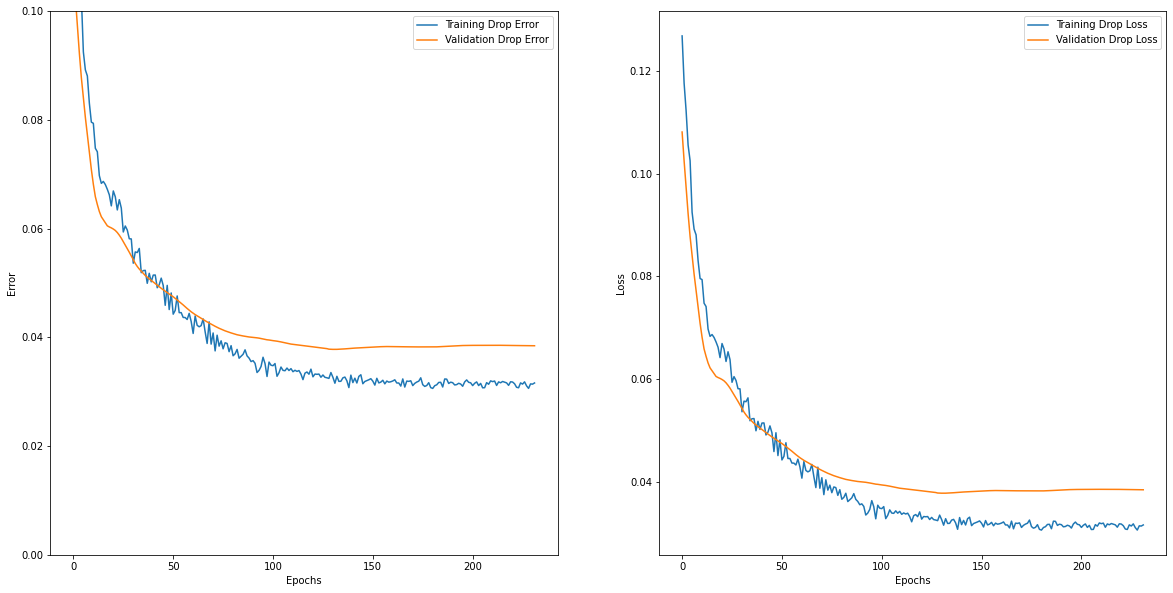

In [42]:
history = drop_predictor.history

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Error")

ax1.plot(history.history['mean_absolute_error'], label="Training Drop Error")
if 'val_mean_absolute_error' in history.history:
    ax1.plot(history.history['val_mean_absolute_error'], label="Validation Drop Error")
ax1.legend()
ax1.set_ylim(0., 0.1)

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

ax2.plot(history.history['loss'], label="Training Drop Loss")
if 'val_loss' in history.history:
    ax2.plot(history.history['val_loss'], label="Validation Drop Loss")
ax2.legend()

In [43]:
print("Evaluate DNN and save results...")

y_train_drops_pred = drop_predictor.predict(X_train_1)

y_test_drops_pred = drop_predictor.predict(X_test_1)

y_test_unseen_drops_pred = drop_predictor.predict(X_test_unseen_1)

y_test_natural_drops_pred = drop_predictor.predict(X_test_natural_1)

Evaluate DNN and save results...


In [44]:
mean_absolute_error(y_train, y_train_drops_pred)

0.03233008026605374

In [45]:
mean_absolute_error(y_test, y_test_drops_pred)

0.029278633954415212

In [46]:
mean_absolute_error(y_test_unseen, y_test_unseen_drops_pred)

0.050669790381567874

In [47]:
mean_absolute_error(y_test_natural, y_test_natural_drops_pred)

0.05669665936027703